## Integrating a System 

The famous Michaleis-Menten equation makes some big assumptions. And it is easy to design an experiment so that the equation works very well. One important idea is that the concentration of enzyme must be small compared to the concentrationn of the substrate. Then the free substrate concentration will be very close to the total substrate concentration at all times.

But what if we want to model the equation more fully? Let us include the effects of the enzyme on substrate concentration. We will still assume the reaction is ireversible and we state the following model scheme for the reaction.

$$ E + S\rightleftharpoons ES \rightarrow P$$

And could be expressed with the following reactions.

$$E + S \xrightarrow{k_1} ES \\ 
ES \xrightarrow{k_{-1}}  E + S\\
ES \xrightarrow{k_{cat}} P + E $$

Now let us integrate all three of these reaction together as a system that describes MM kinetics.

In this notebook will not use analytical methods but instead use the numerical algorithms encapsulated the Python tools. We will use `scipy.integration.solve_ivp()`.

## Using *solve_ivp*

The code below calculates the instantaneous rate of change for each reactant, intermediate and product in the Michaelis-Menten system and then integrates the whole system using numerical methods. Using the reaction scheme outlined above we can define the following rates at a given moment in time.

$$\frac{d}{dt}[S] = -(k_1 [S][E])+(k_{-1}[ES])\\

\frac{d}{dt}[E] = -(k_1 [S][E])+(k_{-1}[ES])+(k_{cat}  [ES])\\

\frac{d}{dt}[ES] = (k_1 [S][E])-(k_{cat}[ES])-(k_{-1}  [ES])\\
    
\frac{d}{dt}[P] = k_{cat} [ES]$$

It is possible to integrate the differential equations for all four species in the scheme. But numeric integration is much simpler to set up in *Python*. Observe the code below. We create a function tha calculates the instantaneous rate of change for all four species from known concentrations. We will then send this function into the numeric integration tool of *SciPy*.

Km: 0.00500 M
Vmax: 6000.00 uM min
kcat/Km: 2.0000e+04


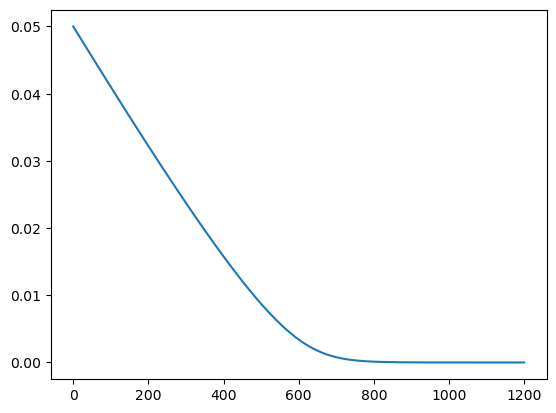

In [1]:
#######################
### import packages ###
#######################

import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rates(t, c, K1, K_1, Kcat):

    S = c[0]; E = c[1]; ES = c[2]  # assign initial conc. from input list c

    r_s = -K1 * c[0] * c[1] + K_1 * c[2]             # rates of each reaction step with give concentration in list c
    r_e = -K1 * c[0] * c[1] + K_1 * c[2] + Kcat * c[2]
    r_es = K1 * c[0] * c[1] - K_1 * c[2] - Kcat * c[2]
    r_p = Kcat * c[2]
    return [r_s, r_e, r_es, r_p]


############################################
### Create a function that describes the ###
### rates of all reactions in the system ###
############################################

k1 = 2E9
k_1 = 1E7
kcat = 1E2
E_conc = 1E-6
S_conc = 0.05

time_end = 1200            ### The end time
n_points = 1200            ### number of points - increase if needed

#########################################
### Create series of time points      ###
#########################################

dt = time_end / n_points          ### time step, delta t
tmax = time_end                   ### max time, s
t_line = np.arange(0, tmax+dt, dt) ### time vector (list of time points)
num = len(t_line)

xmax = time_end           ### change these as you wish
ymax = S_conc

KM_model = (k_1 + kcat)/k1

print(f"Km: {KM_model:0.5f} M")
print(f"Vmax: {kcat*E_conc*1E6*60:0.2f} uM min")
print(f"kcat/Km: {kcat/KM_model:0.4e}")


initial = [S_conc, E_conc, 0, 0]

cc = solve_ivp(rates, [0,tmax], 
               initial, 
               method="Radau",  ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
               t_eval=t_line, 
               args=[k1,k_1,kcat] 
               )

time = cc['t']
yarray = cc['y']
yarray = yarray[0]

plt.plot(time,yarray)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined four plots

In [63]:
import sympy as sym

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x
res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

print("The integrated rate law for the MM equation")
display(eq)                         

##############################################################################
##############################################################################
##############################################################################

from matplotlib import pyplot as plt
import numpy as np

##########################
### create function 
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax

##########################
### Set up parameters
##########################

#E_conc = 1e-6
KM_value = KM_model          ### set KM value
kcat_value = kcat            ### set Vmax value
S0_value = S_conc            ### set initial substrate concentration value

Vmax_value = E_conc * kcat_value

time_end = 1200           ### The end time
n_points = 100            ### number of points - increase if needed

xmax = time_end       ### change these as you wish
ymax = S0_value

##########################
### calculate x and y data
##########################


### the time points
                                                ### t_line comes from the first code block above
c = f(t_line, S0_value, KM_value, Vmax_value)   ### Calculate y according to the function
c = np.real(c)                                  ### the Lambert function produces imaginary numbers. Use on the real component

cc =  yarray
c = c.flatten() 
diff = 100*(cc - c)/c   ### % error  



The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

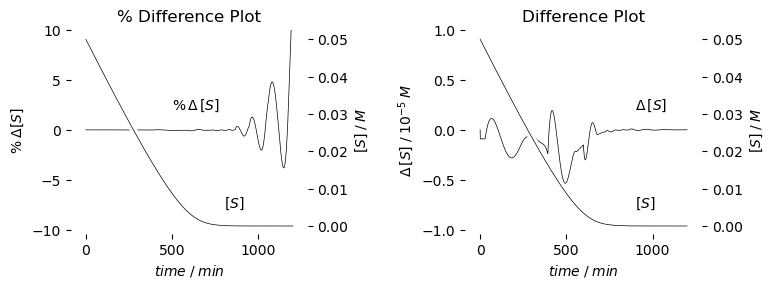

In [69]:
plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

x = t_line
y = diff  ### Percent error

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax1[0].plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

#########################################
### Add more style
#########################################
        

ax1[0].set(ylabel=r"$\% \; \Delta [S]\; $", 
        xlabel=r"$time\; /\; min$",
        title = "% Difference Plot",
        xlim=[None, None],      
        ylim=[-10, 10])

ax1[0].spines[['top','right','bottom','left']].set_visible(False)   ### Make all spines invisible
ax1[0].spines[['left','bottom']].set_position(('axes',-0.02))   ### space spines a little away from 'axes' (plot box)


ax2 = ax1[0].twinx()

ax2.plot(t_line, c,
        linestyle = '-',            ### use a line between points
        linewidth='5',            ### make the line thin
        color = 'white',            ### the line is black
        zorder = 0 )                 ### everything is in layer 0 (the bottom layer in this case)
ax2.plot(t_line, c,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0 )                 ### everything is in layer 0 (the bottom layer in this case)
 
ax2.text(800,0.005,"$[S]$")
ax1[0].text(500, 2.0, "$\%\, \Delta \,[S]$")


ax2.set(ylabel=r"$[S]\; / \;M$", 
        xlim=[None, None],      
        ylim=[-0.001, None])

ax2.spines[['top','right','bottom','left']].set_visible(False)   ### Make all spines invisible
ax2.spines[['right']].set_position(('axes',1.02))   ### space spines a little away from 'axes' (plot box)


######################################################################################

x = t_line
y = (cc-c) * 1E5

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax1[1].plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 1                  ### everything is in layer 0 (the bottom layer in this case)
        )

ax1[1].text(900,0.2,"$\Delta \,[S]$")

#########################################
### Add more style
#########################################
        

ax1[1].set(ylabel=r"$\Delta \,[S]\; /\;10^{-5} \; M$", 
        xlabel=r"$time\; /\; min$",
        title = "Difference Plot",
        xlim=[None, None],      
        ylim=[-1, 1])

ax1[1].spines[['top','right','bottom','left']].set_visible(False)   ### Make all spines invisible
ax1[1].spines[['left','bottom']].set_position(('axes',-0.02))   ### space spines a little away from 'axes' (plot box)


ax3 = ax1[1].twinx()

ax3.plot(t_line, c,
        linestyle = '-',            ### use a line between points
        linewidth='5',            ### make the line thin
        color = 'white',            ### the line is black
        zorder = 3 )                 ### everything is in layer 0 (the bottom layer in this case)

ax3.plot(t_line, c,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 3 )                 ### everything is in layer 0 (the bottom layer in this case)

ax3.text(900,0.005,"$[S]$")

ax3.set(ylabel=r"$[S]\; / \;M$", 
        xlim=[None, None],      
        ylim=[-0.001, None])

ax3.spines[['top','right','bottom','left']].set_visible(False)   ### Make all spines invisible

ax3.spines[['right']].set_position(('axes',1.02))   ### space spines a little away from 'axes' (plot box)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
#########################################
### Output the plot
#########################################

plt.savefig("plot.pdf")     ### export the plot as this
plt.show()                                       ### display the plot in this notebook

